In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from scipy.signal import butter,filtfilt
import cv2
import subprocess
import os, glob

In [ ]:
!wget -q --show-progress --no-check-certificate 'https://docs.google.com/uc?export=download&id=1TyO5kQb0mD9uuhVqFV3e9Tk8WzFG0fae' -O teddy.mp4

teddy.mp4           100%[===================>]   9.02K  --.-KB/s    in 0s      


## Foveation Filtering

In [ ]:
D = 30
G = 18
E = 0.2
T = 0
Id = 9
Fmin = 0.07
alpha = 0.54

In [ ]:
def eccentricity(id,ip,vd,dx):
    x = (id*dx)/(ip*vd)
    return np.arctan(x)

In [ ]:
def fdx(gamma,eccen,eeta,tow):
    return gamma/(eccen + eeta)-tow

In [ ]:
def bx(e,vd,dx):
    part1 = e/(2*vd) + dx/vd
    part2 = -e/(2*vd) + dx/vd

    return np.arctan(part1) - np.arctan(part2)

In [ ]:
def fpn(beta,mdf,fmin):
    return max(fmin,min(beta*mdf,0.5))

In [ ]:
def get_cutoff_frequencies(I,x_fp,y_fp,dist_viewer,img_size,gamma,eeta,tow,f_min):
    m = I.shape[0]
    n = I.shape[1]
    img_pixels = m

    c_freq = np.zeros((m,n),dtype=float)
    for i in range(m):
        for j in range(n):
            

            dist_foveation_point = math.sqrt(((i-x_fp)**2)+((j-y_fp)**2))             # distance of point from foveation point
            e = eccentricity(img_size,img_pixels,dist_viewer,dist_foveation_point)    # eccentricity value which is basically angle subtended at viewer

            mdf = fdx(gamma,e,eeta,tow)                                         # maximum detectable frequency
            beta = bx(img_size/img_pixels,dist_viewer,dist_foveation_point)     # beta value as per paper

            cut_freq = fpn(beta,mdf,f_min)
            c_freq[i][j] = 2*np.pi*cut_freq           # wc for each pixel

    return c_freq

In [ ]:
def h(wc,i,n):
  
    if abs(i) <= n/2:
        return (wc*np.sinc(wc*i))/np.pi
    else:
        return 0

In [ ]:
def w(i,n):
    return alpha + (1-alpha)*np.cos(2*np.pi*i/n)

In [ ]:
def l(wc,i,n):
    return h(wc,i,n)*w(i,n)

In [ ]:
n = 5
np.arange(n)-n//2

array([-2, -1,  0,  1,  2])

In [ ]:
def fov_filt_mat(I):

    m = I.shape[0]
    n = I.shape[1]
    cut_freq = get_cutoff_frequencies(I,m/2,n/2,D,Id,G,E,T,Fmin)
    I_padded = np.pad(I,((m//2,m//2),(n//2,n//2)), 'constant', constant_values=(0,0))

    Icap = np.zeros((m,n),dtype=float)
    for n1 in range(m):
        for n2 in range(n):

            wc = cut_freq[n1][n2]

            Lx = []
            for i1 in range(-m//2,m//2):
                Lx.append(l(wc,i1,m))
                
            Lx = np.array(Lx).reshape(-1,1)
            Ly = []
            for i1 in range(-n//2,n//2):
                Ly.append(l(wc,i1,n))
            Ly = np.array(Ly).reshape(-1,1)

            L = np.dot(Lx,Ly.T)
            A = I_padded[n1:n1+m,n2:n2+n]
            val = np.sum(L*A)
      
            Icap[n1][n2] = val
  
    return Icap






In [ ]:
def fov_filt(I):

    m = I.shape[0]
    n = I.shape[1]
    cut_freq = get_cutoff_frequencies(I,m/2,n/2,D,Id,G,E,T,Fmin)

    Icap = np.zeros((m,n),dtype=float)
    for n1 in range(-m//2,m//2):
        for n2 in range(-n//2,n//2):
      
            wc = cut_freq[n1+m//2][n2+n//2]
            val = 0
            for i1 in range(-m//2,m//2):
                inner = 0
                for i2 in range(-n//2,n//2):
          
                    x = n1-i1+m//2
                    y = n2-i2+n//2

                    if x>=0 and x<m and y>=0 and y<n:
                        inner = inner + I[x][y]*l(wc,i2,n) 
        
                val = val + inner*l(wc,i1,m)
      
        Icap[n1+m//2][n2+n//2] = val
  
    return Icap

## Implementing the above foveation technique on video

In [ ]:
from ipywidgets import Video, Image
from IPython.display import display
import base64

In [ ]:
# getting frames of the video as png files.
fileName='teddy.mp4'

cap = cv2.VideoCapture(fileName)
ret,frame = cap.read()
count=0
while ret:
    
    cv2.imwrite("frame%d.png"%count,frame)
    
    ret,frame = cap.read()
    count+=1

In [ ]:
from PIL import Image as im
from PIL import ImageOps as imo

# storing every fifth frame of the video
gray_images = []
for i in range(0,43,5):
    img = im.open('frame%d.png'%i)
    img_gray = np.array(imo.grayscale(img))
    gray_images.append(img_gray)

In [ ]:
trans_frames = []

for img_gray in gray_images:
    trans_img = fov_filt_mat(img_gray)
    trans_frames.append(trans_img)

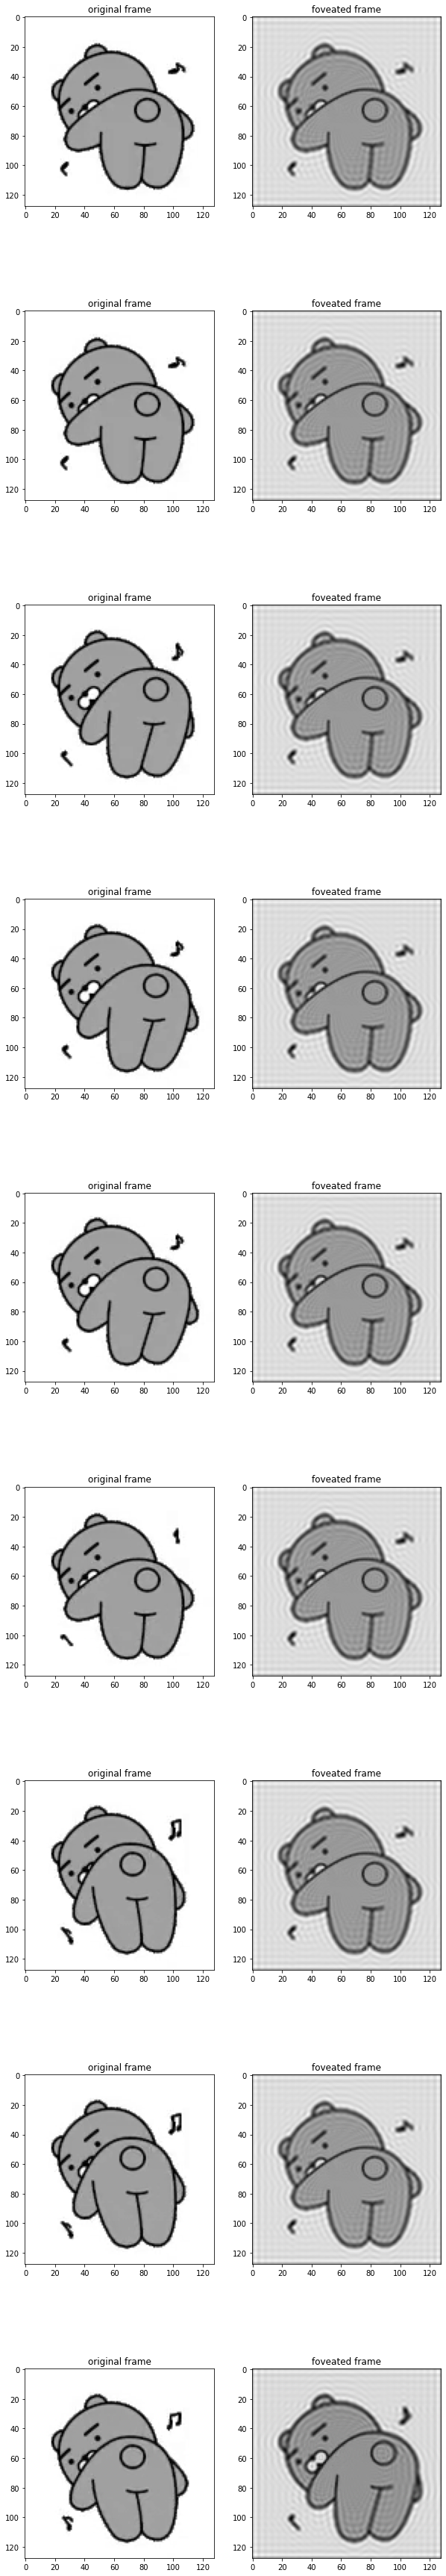

In [ ]:
 # showing frame to frame foveation.
 _, ax = plt.subplots(9,2,figsize=(10,64))

for i in range(9):
  ax[i][0].title.set_text('original frame')
  ax[i][0].imshow(gray_images[i], cmap='gray')
  ax[i][1].title.set_text('foveated frame')
  ax[i][1].imshow(trans_frames[i], cmap='gray')
plt.show()

In [ ]:
%mkdir /content/mp4_videos
%mkdir frames

In [ ]:
def generate_video(frames, video_path):
    folder = 'frames'
    for i in range(len(frames)):
        plt.imsave(folder + "/file%02d.png" % i, frames[i], cmap='gray')

    if os.path.exists(f'{video_path}'):
      os.remove(f'{video_path}')

    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', f'{folder}/file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        f'{video_path}'
    ])
    for file_name in glob.glob(f"{folder}/*.png"):
        os.remove(file_name)
  

In [ ]:
# Original grayscale video
generate_video(gray_images,'/content/mp4_videos/gray_video.mp4')
gray_video = Video.from_file('/content/mp4_videos/gray_video.mp4')
gray_video

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x00\x199mdat\x00\x…

In [ ]:
# Generated foveated video.
generate_video(trans_frames,'/content/mp4_videos/fov_video.mp4')
fov_video = Video.from_file('/content/mp4_videos/fov_video.mp4')
fov_video

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x00\x19\rmdat\x00\…